In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import json
import os
import dill
import numpy as np
import multiprocessing_on_dill as mp
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps

from collections import defaultdict, Counter
from tqdm import tqdm
from itertools import chain
from cityhash import CityHash64
from itertools import groupby

from f723.tools.urs.extraction import assemble_chains, get_sec_struct_model
from f723.tools.dataset.entities import NucleotideFeatures, PairFeatures, PairMeta, PairData, make_pair, Pair

Это функции загрузки датасета в виде всяких namedtuple'ов

In [2]:
DATASET_DIR = '/home/mikhail/bioinformatics/data/dataset_all_60'

In [3]:
def get_batch(index):
    with open(os.path.join(DATASET_DIR, 'batch_{}'.format(index)), 'rb') as infile:
        return dill.load(infile)
    

def get_data():
    return chain.from_iterable((get_batch(i) for i in tqdm(range(30))))

In [4]:
pair_sample = get_batch(0)[0]
pair_sample

PairData(features=PairFeatures(neighbours_left=[None, None, None, None, None, None, NucleotideFeatures(secondary_structure='HI', base='g', fragment_length=3, fragment_index=0), NucleotideFeatures(secondary_structure='HI', base='g', fragment_length=3, fragment_index=1), NucleotideFeatures(secondary_structure='HI', base='c', fragment_length=3, fragment_index=2), NucleotideFeatures(secondary_structure='S', base='c', fragment_length=9, fragment_index=0), NucleotideFeatures(secondary_structure='S', base='g', fragment_length=9, fragment_index=1)], neighbours_right=[None, None, None, None, None, NucleotideFeatures(secondary_structure='HI', base='g', fragment_length=3, fragment_index=0), NucleotideFeatures(secondary_structure='HI', base='g', fragment_length=3, fragment_index=1), NucleotideFeatures(secondary_structure='HI', base='c', fragment_length=3, fragment_index=2), NucleotideFeatures(secondary_structure='S', base='c', fragment_length=9, fragment_index=0), NucleotideFeatures(secondary_stru

Преобразуем фичи из вида, который проиллюстрирован ячейкой выше в вид, который расписан в URS-заметке. Ниже код, который по факту переводит категориальные фичи в onehot encoding чтобы скормить это все в RandomForest.  

Важная фишечка: для каждого нуклеотида из пары имеем длинный вектор из фичей для 11 нуклеотдиов. Назовем нуклеотид в паре с меньшим порядковым номером в цепи левым, а с большим -- правым. Мой код при конструкции пары `Pair(nt_left, nt_right)` обеспечивает, чтобы в `nt_left` хранился всегда левый нуклеотид, а в `nt_right` -- правый. В общем векторе признаков фичи для левого нуклеотида и для правого будут стоять на строго определенных позициях. На эти позиции RandomForest поставит свои жесткие условия, но на самом деле с физической точки зрения, как я понимаю, нет абсолютно никакой разницы, какой нуклеотид является левым, а какой правым. Так что при бесконечных данных RandomForest по-хорошему должен выучить фичи для левого и правого нуклеотидов симметрично. Так как у нас данных сравнительно мало, и может случиться перекос давайте при генерации фичей для каждой пары генерировать 2 зеркальных варианта её вектора признаков, тогда получится, что датасет будет хотя бы симметричен.  

Ещё один момент: не выкидываем нуклеотиды на концах цепочек, но запоняем фичи их несуществующих соседей нулями. Так же для каждого нуклеотида добавим фичу: 1, если данный сосед есть, и 0, если его нет -- это поможет при необходимости дереву определить, есть ли сосед, за одну проверку условия.

In [5]:
class FeaturesExtractor:
    def extract(self, item):
        raise NotImplementedError
    
    def description(self, item):
        raise NotImplementedError


class NucleotideFeaturesExtractor(FeaturesExtractor):
    SECONDARY_STRUCTURES = ['BC', 'BI', 'BP', 'HC', 'HI', 'HP', 'IC', 'II', 'IP', 'JC', 'JI', 'JP', 'S']
    BASES = ['a', 'u', 'g', 'c']
    NUCLEOTIDE_FEATURES_LEN = len(SECONDARY_STRUCTURES) + len(BASES) + 1 + 2
    
    def extract(self, nf):
        if nf is None:
            features = [0] * (self.NUCLEOTIDE_FEATURES_LEN + 1)
        else:
            features = [1]

            nucleotide_secondary_structures = nf.secondary_structure.split(';')
            for secondary_structure in self.SECONDARY_STRUCTURES:
                features.append(int(secondary_structure in nucleotide_secondary_structures))

            for base in self.BASES:
                features.append(int(nf.base == base))

            features.append(int(nf.base in self.BASES))

            features.extend([nf.fragment_length, nf.fragment_index])

        return features
    
    def description(self, nf):
        meta_features = [('nucleotide', 'is_dummy')]
        secondary_structure_features = [('secondary_structure', typ) for typ in self.SECONDARY_STRUCTURES]
        base_features = [('base', base) for base in self.BASES] + [('base', 'rare')]
        fragment_features = [('fragment', 'length'), ('fragment', 'index')]

        return meta_features + secondary_structure_features + base_features + fragment_features


class RelationFeaturesExtractor(FeaturesExtractor):
    RELATIONS = ['LC', 'LR', 'SM']
    
    def extract(self, pair):
        return [int(pair.features.relation == relation) for relation in self.RELATIONS]
    
    def description(self, pair):
        return [('relation', relation) for relation in self.RELATIONS]
    

class PairFeaturesExtractor(FeaturesExtractor):
    def __init__(self):
        self._nucleotide_features_extractor = NucleotideFeaturesExtractor()
        self._relation_features_extractor = RelationFeaturesExtractor()
    
    def extract(self, pair):
        result_features = []
        neighbour_sets = [pair.features.neighbours_left, pair.features.neighbours_right]

        for neighbour_set_permutation in [neighbour_sets, reversed(neighbour_sets)]:
            features = []
            
            for nf in chain.from_iterable(neighbour_set_permutation):
                features.extend(self._nucleotide_features_extractor.extract(nf))
            features.extend(self._relation_features_extractor.extract(pair))
            
            result_features.append(features)
        
        return result_features
    
    def description(self, pair):
        features_description = []
        
        for lr, nfs in [('left', pair.features.neighbours_left), 
                        ('right', pair.features.neighbours_right)]:
            for index, nf in enumerate(nfs):
                for feature_description in self._nucleotide_features_extractor.description(pair):
                    features_description.append((lr, index - (len(nfs) - 1) // 2, feature_description))
        
        features_description.extend(self._relation_features_extractor.description(pair))
        
        return features_description

In [6]:
FEATURES_PATH = os.path.join(DATASET_DIR, 'features.npy')
TARGET_PATH = os.path.join(DATASET_DIR, 'target.npy')
GROUPS_PATH = os.path.join(DATASET_DIR, 'groups.npy')

PAIR_TYPES = ['ss_bps', 'noncanonical_bps', 'random']

In [7]:
FEATURES_SHAPE = (2 * sum(1 for _ in get_data()), 
                  len(PairFeaturesExtractor().description(pair_sample)))

100%|██████████| 30/30 [01:33<00:00,  2.30s/it]


In [8]:
def prepare_features():
    pair_features_extractor = PairFeaturesExtractor()
    pair_sample = get_batch(0)[0]
    features = np.memmap(FEATURES_PATH, shape=FEATURES_SHAPE, mode='w+')
    
    index = 0
    for pair_data in get_data():
        for pair_features in pair_features_extractor.extract(pair_data):
            features[index] = pair_features
            
            index += 1
            
    target = np.repeat([PAIR_TYPES.index(pair_data.meta.type) for pair_data in get_data()], 2)
    pdb_ids = np.repeat([pair_data.meta.pdb_id for pair_data in get_data()], 2)
    
    np.save(TARGET_PATH, target)
    np.save(GROUPS_PATH, pdb_ids)

In [9]:
prepare_features()

100%|██████████| 30/30 [03:15<00:00,  4.92s/it]


In [8]:
def load_features():
    features = np.memmap(FEATURES_PATH, shape=FEATURES_SHAPE)
    target = np.load(TARGET_PATH)
    pdb_ids = np.load(GROUPS_PATH)
    
    return features, target, pdb_ids

In [9]:
features, target, pdb_ids = load_features()

Уберем из датасета пары вторичной структуры. Они есть в датасете, потому что я их тоже собирал, может пригодятся позже.

In [10]:
mask = target != 0  # throw away secondary structure pairs

features = features[mask]
target = target[mask]
pdb_ids = pdb_ids[mask]

In [11]:
len(target) 

6807514

Посмотрим на распределение неканонических пар в зависимости от индекса пары в датасете

In [12]:
ys = np.cumsum(target == 1)
xs = np.arange(ys.shape[0])

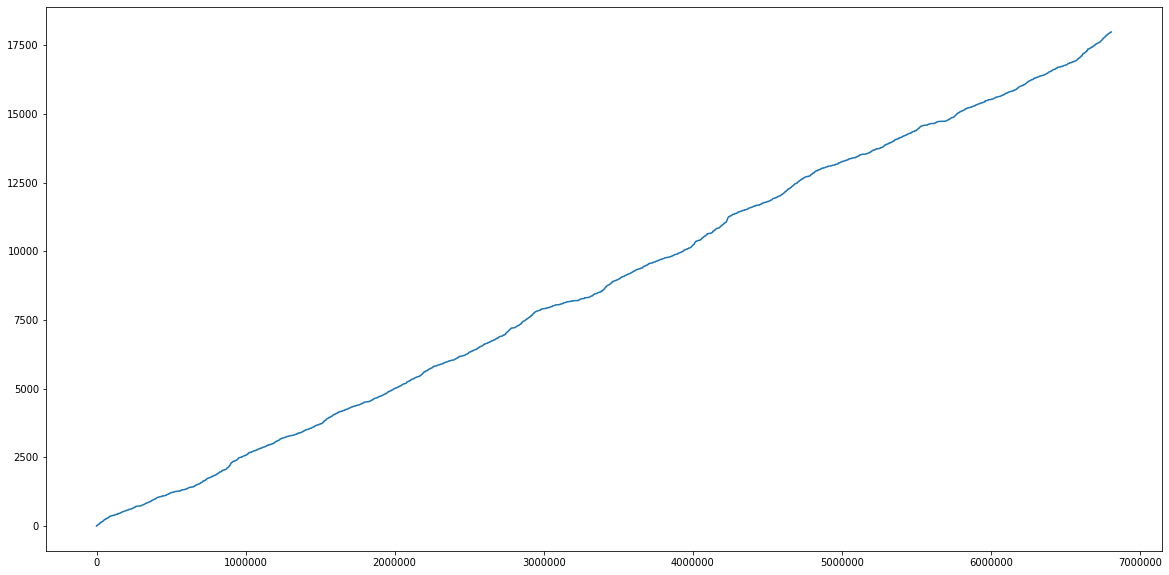

In [13]:
plt.figure(figsize=(20, 10))

plt.plot(xs, ys)

Неканонические пары распределены равномерно, можно спокойно гонять кросс валидацию по группам pdb_id не парясь, что будет сильный дисбаланс между количеством неканонических пар в трейне и в тесте.

In [24]:
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression

In [16]:
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(features, target, pdb_ids)

feature_importances = []
target_pred = np.zeros_like(target)

for train_index, test_index in group_kfold.split(features, target, pdb_ids):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = target[train_index], target[test_index]
    print('Train positive rate: {}, test positive rate: {}'.format(
        np.mean(y_train == 1), np.mean(y_test == 1)))
    
    model = RandomForestClassifier(class_weight='balanced', n_estimators=100, n_jobs=8)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    feature_importances.append(model.feature_importances_)
    target_pred[test_index] = y_pred
    
    print(precision_recall_fscore_support(y_test, y_pred))

Train positive rate: 0.0026536722659665614, test positive rate: 0.002601588276253125
(array([0.89105339, 0.99830379]), array([0.34867307, 0.9998888 ]), array([0.50121753, 0.99909567]), array([   3542, 1357934]))
Train positive rate: 0.0026375495688183027, test positive rate: 0.0026660791010245676
(array([0.89626325, 0.99851223]), array([0.44269972, 0.99986303]), array([0.59266089, 0.99918717]), array([   3630, 1357920]))
Train positive rate: 0.0025787771998196105, test positive rate: 0.002901165019735267
(array([0.9013683 , 0.99825779]), array([0.40025316, 0.99987257]), array([0.55434783, 0.99906453]), array([   3950, 1357572]))
Train positive rate: 0.00264228687266344, test positive rate: 0.0026471309771615176
(array([0.90201135, 0.99863556]), array([0.48529412, 0.99986007]), array([0.63106621, 0.99924744]), array([   3604, 1357870]))
Train positive rate: 0.002703992014721938, test positive rate: 0.002400307897512435
(array([0.90405405, 0.99858089]), array([0.40942472, 0.99989545]), a

In [15]:
TARGET_PRED_PATH = os.path.join(DATASET_DIR, 'target_pred_5_splits_random_forest_n_extimators_100.npy')

In [ ]:
np.save(TARGET_PRED_PATH, target_pred)

In [16]:
target_pred = np.load(TARGET_PRED_PATH)

precision ~90% при recall ~40%. Посмотрим на feature_importances

In [17]:
feature_importances = np.array(feature_importances)
mean_feature_importances = feature_importances.mean(axis=0)

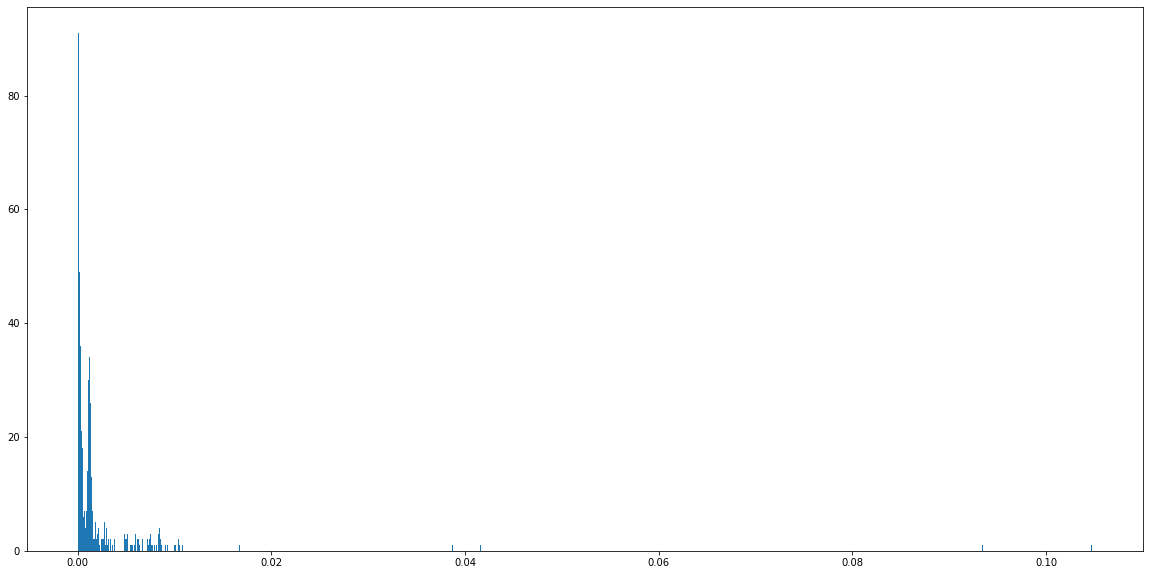

In [18]:
plt.figure(figsize=(20, 10))

plt.hist(mean_feature_importances, bins=1000);

In [19]:
description = PairFeaturesExtractor().description(pair_sample)

In [20]:
[(description[i], mean_feature_importances[i]) for i in np.argsort(mean_feature_importances)[-50:]]

[(('left', -5, ('fragment', 'index')), 0.00521520240391444),
 (('left', 1, ('secondary_structure', 'JC')), 0.005518115755633058),
 (('right', 0, ('fragment', 'index')), 0.005560985617395299),
 (('left', 0, ('fragment', 'index')), 0.005715060132451251),
 (('left', -4, ('fragment', 'length')), 0.005954960870491488),
 (('right', 1, ('secondary_structure', 'JC')), 0.005970973611126348),
 (('right', -4, ('fragment', 'length')), 0.006017691752155202),
 (('left', -5, ('fragment', 'length')), 0.006031446793797587),
 (('right', -3, ('fragment', 'length')), 0.0062132459702177924),
 (('left', -3, ('fragment', 'length')), 0.006229337403402349),
 (('left', 5, ('fragment', 'index')), 0.006288396988802518),
 (('right', -5, ('fragment', 'length')), 0.006379080810146209),
 (('right', 5, ('fragment', 'index')), 0.006424460829475913),
 (('left', -2, ('fragment', 'length')), 0.006706684362614177),
 (('right', -2, ('fragment', 'length')), 0.006714133197457427),
 (('right', 5, ('fragment', 'length')), 0.007

Видим, что фичи, помогающие понять степень близости нуклеотидов в цепочке -- самые важные, между ними вклиниваются фичи для мотивов вторичной структуры, которым нуклеотиды принадлежат. Рассмотрим фичи мотивов вторичной структуры подробнее, так как их много.

In [21]:
[(description[i], mean_feature_importances[i]) 
 for i in np.argsort(mean_feature_importances)[-50:] 
 if len(description[i]) == 3 and description[i][2][0] == 'secondary_structure']

[(('left', 1, ('secondary_structure', 'JC')), 0.005518115755633058),
 (('right', 1, ('secondary_structure', 'JC')), 0.005970973611126348),
 (('left', 1, ('secondary_structure', 'HC')), 0.007526206265346269),
 (('right', 1, ('secondary_structure', 'IC')), 0.007925553323396485),
 (('left', 0, ('secondary_structure', 'S')), 0.008380392317568548),
 (('right', 0, ('secondary_structure', 'S')), 0.008440361275793541),
 (('right', 1, ('secondary_structure', 'HC')), 0.008464581190567614),
 (('left', 1, ('secondary_structure', 'IC')), 0.008515390477778845),
 (('right', 2, ('secondary_structure', 'S')), 0.00868721514009012),
 (('left', 2, ('secondary_structure', 'S')), 0.009043330013348767),
 (('left', 1, ('secondary_structure', 'S')), 0.038740722629474325),
 (('right', 1, ('secondary_structure', 'S')), 0.04162590506678272)]

В ячейке выше -- самые важные фичи мотивов вторичной структуры. Рассмотрим категориальные понуклеотидные фичи -- то есть все понуклеотидные фичи, кроме длины фрагмента и индекса во фрагменте. Рассмотрим их для каждого из нуклеотидов в паре, а так же для 2-х их соседей вперед (так как эти фичи отмечены RandomForest самыми важными). Кажется, что так как подобная конфигурация оснований вблизи нуклеотидов в паре имеет совсем немного допустимых значений, то эти фичи в принципе не должны помогать хорошо отличить неканонические спаривания от случайных не связанных пар. Для того чтобы это проверить, посчитаем количество неканонических спариваний, для которых есть несвязанная пара нуклеотидов с такой же конфигурацией окрестности.

In [22]:
def make_mask(indices):
    mask = np.zeros(len(features[0]), dtype=np.bool)

    for index in indices:
        begin = index * (NucleotideFeaturesExtractor.NUCLEOTIDE_FEATURES_LEN + 1)
        for i in range(begin, begin + NucleotideFeaturesExtractor.NUCLEOTIDE_FEATURES_LEN - 1):
            mask[i] = True
    
    return mask

In [23]:
left_mask = make_mask([5, 6, 7])
right_mask = make_mask([16, 17, 18])


def make_hash(x):
    return tuple(sorted([CityHash64(x[left_mask]), CityHash64(x[right_mask])]))

In [24]:
feature_repeat = defaultdict(list)

for i, (x, y) in tqdm(enumerate(zip(features, target))):
    feature_repeat[make_hash(x)].append((i, y))

6807514it [00:35, 191502.22it/s]


In [29]:
count = 0

for key, value in feature_repeat.items():
    if len({b for a, b in value}) > 1:
        count += sum(1 for a, b in value if b == 1)
    
count

14086

In [26]:
np.sum(target == 1)

17994

Вышло, что неканонических спариваний, для которых есть такая же конфигурация среди случайных пар очень много.  

Попробуем теперь посмотреть на те 40% пар, которые RandomForest смог выделить с большой точностью -- true_positive. Попытаемся понять, чем они отличаются от оставшихся 60% -- false_negative

In [30]:
true_positive_mask = (target == 1) & (target_pred == 1)
false_negative_mask = (target == 1) & (target_pred == 2)

In [31]:
np.sum(true_positive_mask), np.sum(false_negative_mask)

(7510, 10484)

Посмотрим, легко ли можно отличить true_positive от false_negative пар.

In [19]:
new_features = np.array(list(features[true_positive_mask]) + list(features[false_negative_mask]), dtype=np.uint8)
new_target = np.zeros(true_positive_mask.sum() + false_negative_mask.sum(), dtype=np.uint8)
new_target[:true_positive_mask.sum()] = 1
new_target[-false_negative_mask.sum():] = 2

In [22]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True)
stratified_kfold.get_n_splits(new_features, new_target)

feature_importances = []

for train_index, test_index in stratified_kfold.split(new_features, new_target):
    X_train, X_test = new_features[train_index], new_features[test_index]
    y_train, y_test = new_target[train_index], new_target[test_index]
    print('Train positive rate: {}, test positive rate: {}'.format(
        np.mean(y_train == 1), np.mean(y_test == 1)))
    
    model = RandomForestClassifier(n_estimators=100, n_jobs=8)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    feature_importances.append(model.feature_importances_)
    
    print(precision_recall_fscore_support(y_test, y_pred))

Train positive rate: 0.41736714136853076, test positive rate: 0.4173381494859683
(array([0.84731324, 0.89917993]), array([0.8608522 , 0.88888889]), array([0.85402906, 0.8940048 ]), array([1502, 2097]))
Train positive rate: 0.41736714136853076, test positive rate: 0.4173381494859683
(array([0.84724005, 0.91082803]), array([0.87882823, 0.88650453]), array([0.8627451 , 0.89850169]), array([1502, 2097]))
Train positive rate: 0.41736714136853076, test positive rate: 0.4173381494859683
(array([0.84818068, 0.92518703]), array([0.90013316, 0.88459704]), array([0.87338501, 0.90443686]), array([1502, 2097]))
Train positive rate: 0.41736714136853076, test positive rate: 0.4173381494859683
(array([0.83226633, 0.90083456]), array([0.86551265, 0.87505961]), array([0.84856397, 0.88776004]), array([1502, 2097]))
Train positive rate: 0.4173381494859683, test positive rate: 0.41745414118954977
(array([0.83653846, 0.9033366 ]), array([0.86884154, 0.87833969]), array([0.85238406, 0.8906628 ]), array([1502

Да, кажется random forest отличает их с неплохой точностью, посмотрим, какие фичи при этом обладают наибольшим весом.

In [113]:
feature_importances = np.array(feature_importances)
mean_feature_importances = feature_importances.mean(axis=0)

In [114]:
[(description[i], mean_feature_importances[i]) for i in np.argsort(mean_feature_importances)[-50:]]

[(('right', 1, ('base', 'g')), 0.0038051084488939456),
 (('right', -2, ('base', 'g')), 0.0038660642923207173),
 (('left', 1, ('base', 'a')), 0.00419629869004601),
 (('right', 1, ('base', 'a')), 0.004383199329389249),
 (('left', 1, ('secondary_structure', 'HC')), 0.005931556691182516),
 (('right', 1, ('secondary_structure', 'HC')), 0.006529142388940809),
 (('right', 4, ('fragment', 'index')), 0.00735630555947475),
 (('left', 4, ('fragment', 'index')), 0.007399725585607679),
 (('right', 3, ('fragment', 'index')), 0.007498968194134767),
 (('left', 3, ('fragment', 'index')), 0.007712231935208594),
 (('left', 1, ('fragment', 'index')), 0.007796814698539517),
 (('right', 1, ('fragment', 'index')), 0.007865007704274167),
 (('left', 5, ('fragment', 'index')), 0.008028359023999362),
 (('right', 2, ('fragment', 'index')), 0.008061445826290684),
 (('right', 5, ('fragment', 'index')), 0.00820144121500702),
 (('right', -1, ('fragment', 'index')), 0.0082143472944043),
 (('left', 2, ('fragment', 'ind

Окей, посмотрели, выводов пока никаких сделать не могу, длина фрагмента так длина фрагмента.

Теперь соберем в отдельной тетрадке, а в этой тетрадке загрузим типы спариваний по Леонтису. Посмотрим на распределение false_negative и false_positive в разрезе по типам спариваний: вдруг мы не умеем классифицировать пару типов спариваний, а остальные умеем?

In [19]:
lw_types = np.repeat(np.load(os.path.join(DATASET_DIR, 'lw.npy')), 2)[mask]

In [20]:
true_positive_counter = Counter(lw_types[true_positive_mask])
false_negative_counter = Counter(lw_types[false_negative_mask])
keys = list(true_positive_counter)

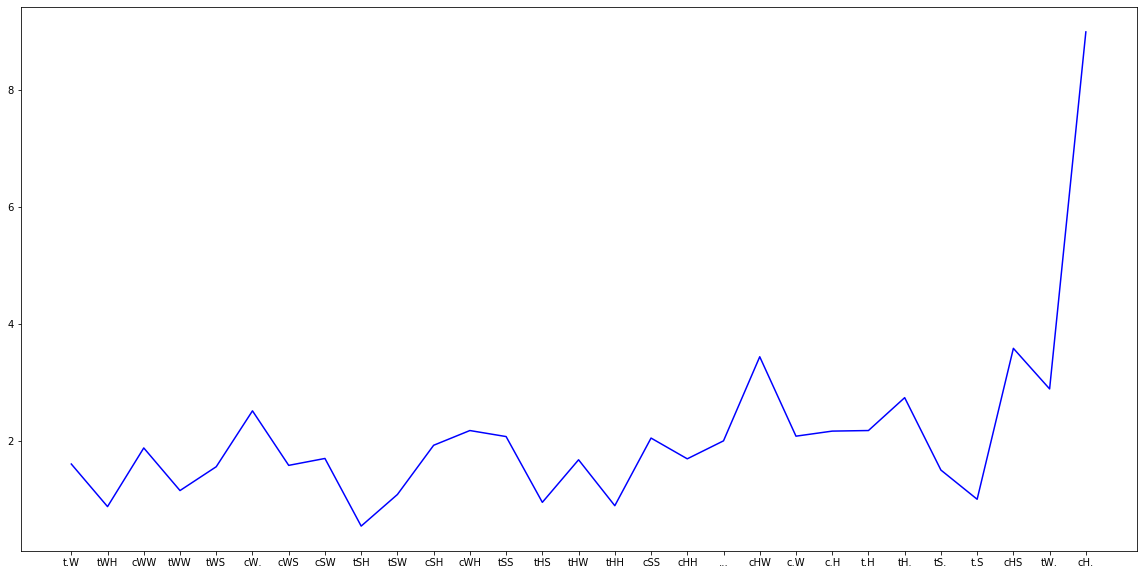

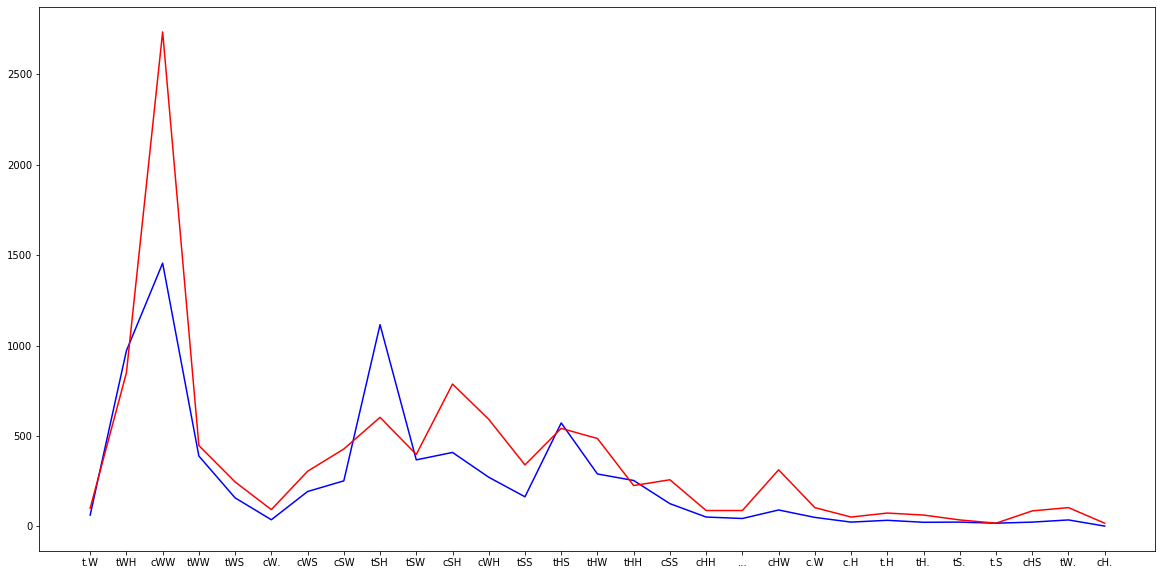

In [28]:
xs = np.arange(len(keys))
true_positive_num = np.array([true_positive_counter[k] for k in keys])
false_negative_num = np.array([false_negative_counter[k] for k in keys])

plt.figure(figsize=(20, 10))
plt.xticks(ticks=xs, labels=keys)
plt.plot(xs, false_negative_num / true_positive_num, c='b')

plt.figure(figsize=(20, 10))
plt.xticks(ticks=xs, labels=keys)
plt.plot(xs, true_positive_num, c='b')
plt.plot(xs, false_negative_num, c='r')

Отношение FN / TP примерно одно и то же по всем типам спариваний (за исключением пары типов, но там очень мало представителей -- так что на них можно не обращать внимания). Это значит, что то как random forest классифицирует вероятно содержит мало информации о типе по Леонтису. Это ещё и указывает на то, что скорее всего классифицировать неканонические спаривания на тип по Леонтису -- непростая задача.

Хорошо, true_positive классифицируются с высоким precision и неплохо отличаются от false_negative. Интересно теперь: если мы выкинем true_positive из выборки, и будем работать со сложными false_negative -- каким будет скор классификатора?

In [33]:
selected_features = features[~true_positive_mask]
selected_target = target[~true_positive_mask]
selected_pdb_ids = pdb_ids[~true_positive_mask]

In [34]:
len(selected_target)

6800004

In [ ]:
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(selected_features, selected_target, selected_pdb_ids)

for train_index, test_index in group_kfold.split(selected_features, selected_target, selected_pdb_ids):
    X_train, X_test = selected_features[train_index], selected_features[test_index]
    y_train, y_test = selected_target[train_index], selected_target[test_index]
    print('Train positive rate: {}, test positive rate: {}'.format(
        np.mean(y_train == 1), np.mean(y_test == 1)))
    
    model = RandomForestClassifier(class_weight='balanced', n_estimators=100, n_jobs=8)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print(precision_recall_fscore_support(y_test, y_pred))

Train positive rate: 0.0015158010216123887, test positive rate: 0.0016456172755989812
(array([0.17307692, 0.99836749]), array([0.0080429 , 0.99993666]), array([0.01537148, 0.99915146]), array([   2238, 1357738]))
Train positive rate: 0.0015542316553329998, test positive rate: 0.001491893116041932


0.0080429 -- чудовищно низкий recall, выходит random forest вообще не может отличить false_negative от случайных пар с помощью предложенных фичей. Нужно выяснить, почему так происходит.